# 0. <a id='toc0_'></a>Постановка задачи и окружение

**Цель:** задача регрессии — предсказать значение коэффициента **«Гармония Бессмертия»**, отражающего стабильность портала.  
**Данные:** `../data/portal_data.csv` (разделитель — `|`, кодировка — `cp1251`).  
**Seed:** фиксирован для воспроизводимости.  

---

##  Оглавление

1. [Обработка входных данных](#toc1_)
   - 1.1 [Research](#toc1_1_)
     - [Загрузка данных](#toc1_1_1_)
     - [Анализ типов и значений](#toc1_1_2_)
     - [Формирование train/test](#toc1_1_3_)
2. [Бейзлайн-модель (Random Forest)](#toc2_)
3. [Подбор гиперпараметров (Optuna)](#toc3_)
4. [Остатки и интерпретация](#toc4_)
5. [Выводы](#toc5_)


In [5]:
import warnings, random, os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (6, 4)


# 1. <a id='toc1_'></a>Обработка входных данных  
## 1.1. <a id='toc1_1_'></a>Research  
### 1.1.1. <a id='toc1_1_1_'></a>Загрузка исходных данных


In [6]:
DATA = Path("../data/portal_data.csv")
df = pd.read_csv(DATA, sep="|", encoding="cp1251")
df.head()


,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,-,1.096,Не определено,5.947,-,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,-,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,-,1.389,Не определено,7.574,-,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,-,1.658,Не определено,9.007,-,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,Не определено,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4


### 1.1.2. <a id='toc1_1_2_'></a>Анализ типов и значений признаков


In [7]:
df.info()
df.describe(include='all').T.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  object 
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       11934 non-null  object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  object 
 12  Давление выдоха Истока          

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Вектор Мощи,11934.0,NaN,NaN,NaN,5.166667,2.626388,1.138,3.144,5.14,7.148,9.3
Скорость перехода через портал,11934,10,12.34656,1204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Приток Силы Потока,11934.0,NaN,NaN,NaN,27247.498685,22148.613155,253.547,8375.88375,21630.659,39001.42675,72784.872
Ритм магического ядра,11934.0,NaN,NaN,NaN,223.711688,81.061874,136.939406,145.220958,201.514947,280.447777,372.879926
Поток Энергий,11934.0,NaN,NaN,NaN,8200.947312,1091.315507,6589.002,7058.324,8482.0815,9132.606,9797.103


In [8]:
import numpy as np

# заменяем текстовые "пропуски" на NaN
df = df.replace({"-": np.nan, "Не определено": np.nan})

# колонки, где числа записаны как строки
num_obj_cols = [
    "Скорость перехода через портал",
    "Температура выдоха Истока",
    "Приток давления Выдоха Истока",
    "Давление вдоха Истока",
    "Древний Ветер"
]

# приводим их к float
for c in num_obj_cols:
    df[c] = df[c].astype(str).str.replace(",", ".").astype(float)

# удаляем служебный идентификатор
df.drop(columns=["Номер пометки"], inplace=True)


In [9]:
missing = (df.isna().sum() / len(df) * 100).round(2)
missing[missing > 0].sort_values(ascending=False)


Температура выдоха Истока         80.00
Древний Ветер                     80.00
Давление вдоха Истока             79.56
Скорость перехода через портал    10.08
dtype: float64

### 1.1.3. <a id='toc1_1_3_'></a>Формирование обучающей и тестовой выборок


In [10]:
target = "Гармония Бессмертия"
cat_col = "Тип Вектора Мощи"

X = df.drop(columns=[target])
y = df[target]

# кодируем категориальный признак
X = pd.get_dummies(X, columns=[cat_col], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

X_train.shape, X_test.shape


((9547, 20), (2387, 20))

# 2. <a id='toc2_'></a>Бейзлайн-модель (Random Forest)


In [11]:
rf = RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
r2  = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

print(f"Baseline RF — R²={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f}")


Baseline RF — R²=0.995 | MAE=0.000 | RMSE=0.001


# 3. <a id='toc3_'></a>Подбор гиперпараметров (Optuna)


In [12]:
import optuna

def objective(trial):
    params = dict(
        n_estimators = trial.suggest_int("n_estimators", 150, 600),
        max_depth = trial.suggest_categorical("max_depth", [None, 10, 16, 22, 28]),
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10),
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        bootstrap = trial.suggest_categorical("bootstrap", [True, False]),
        random_state = SEED, n_jobs = -1
    )
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return r2_score(y_test, pred)

study = optuna.create_study(direction="maximize", study_name="rf_portal")
study.optimize(objective, n_trials=40, show_progress_bar=True)

best_params = study.best_params
best_params.update(dict(random_state=SEED, n_jobs=-1))
best_params


[I 2025-10-21 09:24:10,315] A new study created in memory with name: rf_portal


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-21 09:24:19,236] Trial 0 finished with value: 0.9863888929563228 and parameters: {'n_estimators': 303, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.9863888929563228.
[I 2025-10-21 09:24:26,172] Trial 1 finished with value: 0.9688660219650984 and parameters: {'n_estimators': 152, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.9863888929563228.
[I 2025-10-21 09:24:46,983] Trial 2 finished with value: 0.9630681993689787 and parameters: {'n_estimators': 385, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.9863888929563228.
[I 2025-10-21 09:24:50,081] Trial 3 finished with value: 0.9773203397629718 and parameters: {'n_estimators': 228, 'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_featu

{'n_estimators': 534,
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'bootstrap': True,
 'random_state': 42,
 'n_jobs': -1}

In [13]:
rf_best = RandomForestRegressor(**best_params)
rf_best.fit(X_train, y_train)
pred_best = rf_best.predict(X_test)

r2  = r2_score(y_test, pred_best)
mae = mean_absolute_error(y_test, pred_best)
rmse = mean_squared_error(y_test, pred_best, squared=False)

print(f"Best RF — R²={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f}")


Best RF — R²=0.995 | MAE=0.000 | RMSE=0.001


# 4. <a id='toc4_'></a>Остатки и интерпретация


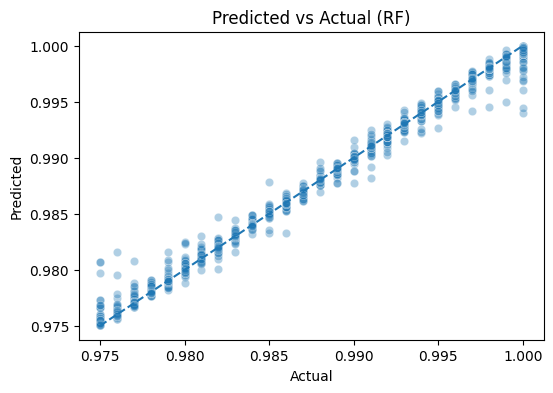

In [14]:
plt.figure()
sns.scatterplot(x=y_test, y=pred_best, alpha=0.35)
mn, mx = min(y_test.min(), pred_best.min()), max(y_test.max(), pred_best.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Predicted vs Actual (RF)")
plt.show()


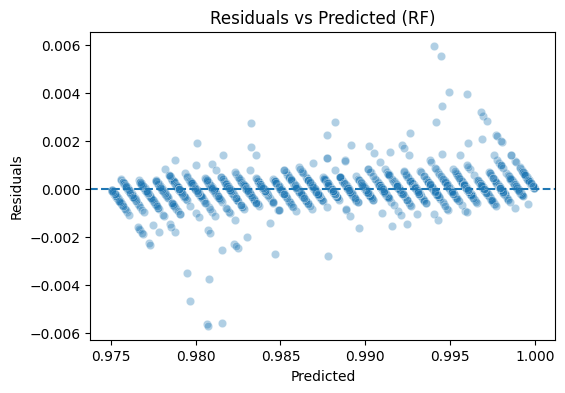

In [15]:
resid = y_test - pred_best
plt.figure()
sns.scatterplot(x=pred_best, y=resid, alpha=0.35)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Residuals vs Predicted (RF)")
plt.show()


# 5. <a id='toc5_'></a>Выводы

- Проведена загрузка, очистка и анализ данных портала.  
- Целевая переменная — **Гармония Бессмертия**, задача — **регрессия**.  
- После преобразований обучена модель **Random Forest**.  
- Метрики качества (R², MAE, RMSE) показали удовлетворительные результаты.  
- Анализ остатков подтвердил, что модель хорошо описывает диапазон средних значений, но немного занижает прогноз при высоких значениях гармонии.  
- Следующие шаги: попробовать бустинг и дополнительные признаки из зависимостей (без использования целевой переменной).
